In [1]:
import warnings
warnings.filterwarnings("ignore") # to ignore all future warnings

## 1. Preparing the dataset

### 1.1 Scraping news articles from the web

This process takes on average between 2 and 15min, depending on how many website links are to be scraped, how many articles in these links are found and how much computing ressources the machine has on which the code runs.

In [2]:
from datetime import *; from dateutil.relativedelta import *
import calendar

yesterday = str(date.today() - timedelta(days=1))

yesterday

'2020-01-18'

In [3]:
import feedparser as fp
import newspaper
from newspaper import Article
import time
from time import mktime
from datetime import datetime
from datetime import date
import pandas as pd
import json
import pprint
import dateutil

#### 1 Website data ####

with open('NewsPapers_finance.json') as data_file: #Loads the JSON files with news URLs
    companies = json.load(data_file) # change to sources instead of companies

#### for testing ####

#companies = {"CNN": {"rss": ["http://rss.cnn.com/rss/cnn_topstories.rss"]},
#             "CNBC":{"rss": ["https://www.cnbc.com/id/10000664/device/rss/rss.html"]}}

#####################

#### 2 Todays date - for filtering the articles by todays date ####
today = str(date.today()) 
print("Today's date:", today)

#### 3 Scraping the news articles ####

text_list, source_list, article_list, date_list, time_list, title_list, image_list, keywords_list, summaries_list = [], [], [], [], [], [], [], [], []

for source, content in companies.items():
    source_list.append(source)
    source_list_unique = set(source_list)
    for rss, links in content.items():
        for url in content["rss"]:
            d = fp.parse(url)
            article = {}
            for entry in d.entries:
                if hasattr(entry, 'published') and (((dateutil.parser.parse(getattr(entry, 'published'))).strftime("%Y-%m-%d") == today)  or ((dateutil.parser.parse(getattr(entry, 'published'))).strftime("%Y-%m-%d") == yesterday)):
                    article['source'] = source
                    # print(article["source"]) ##
                    source_list.append(article['source'])

                    # getting the article URLs
                    article['link'] = entry.link
                    article_list.append(article['link'])

                    # getting the article published dates
                    date = (getattr(entry, 'published'))
                    date = dateutil.parser.parse(date)
                    date_formated = date.strftime("%Y-%m-%d")
                    time_formated = date.strftime("%H:%M:%S %Z") # hour, minute, timezone (converted)
                    date_list.append(date_formated)
                    time_list.append(time_formated)

                    # "downloading" the articles
                    content = Article(entry.link)
                    try:
                        content.download()
                        content.parse()  
                        content.nlp()
                    except Exception as e: 
                        # in case the download fails, it prints the error and immediatly continues with downloading the next article
                        print(e)
                        print("continuing...")

                    # save the "downloaded" content
                    title = content.title #extract article titles
                    image = content.top_image #extract article images
                    image_list.append(image)
                    keywords = content.keywords
                    keywords_list.append(keywords)
                    title_list.append(title)
                    text = content.text
                    text_list.append(text)
                    summaries = content.summary
                    summaries_list.append(summaries)
                
#creating dicts for formatting and inserting to pandas df
source_dict = {'source':source_list}
link_dict = {'link':article_list}
date_dict = {'published_date':date_list}
time_dict = {'published_time':time_list}
title_dict = {'title':title_list}
text_dict = {'text':text_list}
keyword_dict = {'keywords':keywords_list}
image_dict = {'image':image_list}
summary_dict = {'summary':summaries_list}

#creating separate pandas dfs for each feature
source_df = pd.DataFrame(source_dict, index=None)
link_df = pd.DataFrame(link_dict, index=None)
date_df = pd.DataFrame(date_dict, index=None)
time_df = pd.DataFrame(time_dict, index=None)
title_df = pd.DataFrame(title_dict, index=None)
text_df = pd.DataFrame(text_dict, index=None)
keyword_df = pd.DataFrame(keyword_dict, index=None)
image_df = pd.DataFrame(image_dict, index=None)
summary_df = pd.DataFrame(summary_dict, index=None)

#join all pandas dfs together
news_df = source_df.join(link_df).join(date_df).join(time_df).join(title_df).join(text_df).join(keyword_df).join(image_df).join(summary_df)


# after running, pandas DF sould be created with link, published_date, published_time, title and text

Today's date: 2020-01-19
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4317796-green-organic-dutchman-profits-unlikely-in-2020?source=feed_all_articles on URL https://seekingalpha.com/article/4317796-green-organic-dutchman-profits-unlikely-in-2020?source=feed_all_articles
continuing...
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4317794-saudi-aramco-gets-2-trillion-valuation?source=feed_all_articles on URL https://seekingalpha.com/article/4317794-saudi-aramco-gets-2-trillion-valuation?source=feed_all_articles
continuing...
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4317785-adobe-dont-chase-stock?source=feed_all_articles on URL https://seekingalpha.com/article/4317785-adobe-dont-chase-stock?source=feed_all_articles
continuing...
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekinga

In [4]:
for i in source_list_unique:
    print(source_list.count(i) , " articles downloaded from ", i)
print("\n" , len(source_list) , " total articles downloaded")

17  articles downloaded from  New York Times
30  articles downloaded from  Investing.com
1  articles downloaded from  CBN
13  articles downloaded from  Fortune
11  articles downloaded from  MarketWatch
20  articles downloaded from  CNBC
4  articles downloaded from  Skynews
14  articles downloaded from  Wall Street Journal
1  articles downloaded from  CNN
1  articles downloaded from  Financial Times
156  articles downloaded from  Business Standard
25  articles downloaded from  The Guardian
1  articles downloaded from  Wall Street Survivor
31  articles downloaded from  Seeking Alpha
11  articles downloaded from  Nasdaq
1  articles downloaded from  Reddit
57  articles downloaded from  Yahoo Finance
1  articles downloaded from  Daily Telegraph

 395  total articles downloaded


### 1.2. Filtering and cleaning the dataset

In order to run some analysis on the titles and text content of the articles, we need to clean them.
We first filter all the articles we scraped by todays date. 
For cleaning the titles and article content text, we go through the following steps:

*  remove stopwords (i.e. "a", "for", "when", "you", "if",... etc. that would impact the accuracy of our similarity analysis)
*  remove punctuation
*  remove numbers
*  remove names of the source website in the article text (we noticed, that f.e. CNN often mentions "CNN" in their articles, which would impact on the accuracy of our similarty analysis)
*  make the sentences lower case

In [5]:
import re
import nltk
nltk.download('wordnet')
#from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elandman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# 1 Removing missing titles i.e. articles extracted without title, text or image

news_df_daily = news_df[news_df.title != ""]
news_df_daily = news_df_daily[news_df_daily.text != ""]
news_df_daily = news_df_daily[news_df_daily.image != ""]

news_df_daily = news_df_daily[news_df_daily.title.str.count('\s+').ge(3)] #keep only titles having more than 3 spaces = length
news_df_daily = news_df_daily[news_df_daily.text.str.count('\s+').ge(20)] #keep only titles having more than 20 spaces = length

# 2 Make all letters lower case
news_df_daily["clean_title"] = news_df_daily["title"].str.lower()
news_df_daily["clean_text"] = news_df_daily["text"].str.lower()

# 3 Filter out the stopwords
stop = stopwords.words('english')

news_df_daily["clean_title"] = ((news_df_daily["clean_title"].str.replace("'s",'')).str.replace("’s",''))
news_df_daily["clean_text"] = ((news_df_daily["clean_text"].str.replace("'s",'')).str.replace("’s",''))

news_df_daily['clean_title'] = news_df_daily['clean_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
news_df_daily['clean_text'] = news_df_daily['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# 4 Remove sources, punctuation ('[^\w\s]','') and numbers ('\d+', '')
sources_list = (list(source_dict.values()))
for i in sources_list:
    sources_set = set(i)
sources_set = [x.lower() for x in sources_set]
sources_to_replace = dict.fromkeys(sources_set, "") # replace every source with "" nothing

news_df_daily["clean_title"] = (((news_df_daily["clean_title"].str.replace('[^\w\s]',''))
                                .str.replace('\d+', '')).replace(sources_to_replace, regex=True))


news_df_daily["clean_text"] = (((news_df_daily["clean_text"].str.replace('[^\w\s]',''))
                                .str.replace('\d+', ''))
                               .replace(sources_to_replace, regex=True))

news_df_daily = news_df_daily[~news_df_daily["clean_title"].str.contains("washington post")] 
# remove washington post articles, since these cannot bet scraped
# TODO if test is shorter than... filter out #####################################

# 4 Remove non-ascii characters
news_df_daily["clean_title"] = news_df_daily["clean_title"].apply(unidecode)
news_df_daily["clean_text"] = news_df_daily["clean_text"].apply(unidecode)

# 5 Lemmatize words
w_tokenizer, lemmatizer = nltk.tokenize.WhitespaceTokenizer() , nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

news_df_daily["clean_title"] = (news_df_daily["clean_title"].apply(lemmatize_text).apply(lambda x: ' '.join([word for word in x])))

news_df_daily["clean_text"] = (news_df_daily["clean_text"].apply(lemmatize_text).apply(lambda x: ' '.join([word for word in x])))

news_df_daily["keywords"] = news_df_daily["keywords"].apply(lambda x: ' '.join([word for word in x]))

# 6 Drop Duplicates

news_df_daily = (news_df_daily.drop_duplicates(("title"))).sort_index()
news_df_daily = (news_df_daily.drop_duplicates(("link"))).sort_index()

news_df_daily = news_df_daily.reset_index(drop=True)

##

pd.set_option('display.max_colwidth', 20)

news_df_daily

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
0,CNN,https://www.cnbc...,2020-01-18,18:06:51 UTC,Amazon reportedl...,People shop at t...,reportedly termi...,https://image.cn...,People shop at t...,amazon reportedl...,people shop newl...
1,CNBC,https://www.cnbc...,2020-01-18,15:14:38 UTC,NBCUniversal rev...,Toward the end o...,shows million me...,https://image.cn...,Toward the end o...,nbcuniversal rev...,toward end nbcun...
2,CNBC,https://www.cnbc...,2020-01-18,18:30:56 UTC,Stocks appear de...,Traders work on ...,detached stocks ...,https://image.cn...,The S&P 500 has ...,stock appear det...,trader work floo...
3,CNBC,https://www.cnbc...,2020-01-18,12:26:05 UTC,In the stock mar...,The stock market...,stocks number de...,https://image.cn...,The stock market...,stock market bec...,stock market tra...
4,CNBC,https://www.cnbc...,2020-01-18,14:14:03 UTC,Wall Street's be...,Traders signal o...,good exceptional...,https://image.cn...,Wall Street firm...,wall street bele...,trader signal of...
5,CNBC,https://www.cnbc...,2020-01-18,14:01:01 UTC,The 2020 Oscar n...,Oscar Statue at ...,women directors ...,https://image.cn...,Oscar Statue at ...,oscar nomination...,oscar statue aca...
6,CNBC,https://www.cnbc...,2020-01-18,00:06:06 UTC,Wall Street expe...,The Jan. 29 earn...,estimates job ep...,https://image.cn...,He estimates the...,wall street expe...,jan earnings cal...
7,CNBC,https://www.cnbc...,2020-01-19,16:46:39 UTC,'Bad Boys For Li...,Will Smith and M...,expectations mil...,https://image.cn...,Will Smith and M...,bad boy life bre...,smith martin law...
8,CNBC,https://www.cnbc...,2020-01-19,16:01:01 UTC,Review: The 2020...,The 2020 Genesis...,hogan g70 review...,https://image.cn...,The 2020 Genesis...,review genesis g...,genesis g mack h...
9,CNBC,https://www.cnbc...,2020-01-19,16:44:46 UTC,SpaceX closes in...,The four main pa...,capsule astronau...,https://image.cn...,Launched on top ...,spacex close fly...,four main parach...


## 2. Analyzing the dataset

In this step, we apply several different analysis methods, in order to define which articles out of those we scraped are **most relevant** for portfolio trading customers and **cover trending financial topics**.

### 2.1. Cosine similarity

Cosine similarity is a metric for measuring the similarity between two sentences. It creates numbered vectors out of sentences and measures the **cosine of the angle between them**.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d" alt="Cosine similarity formula" title="Cosine similarity formula" />

where
* A ........... vector A
* A • B ..... dot product between vector A and B
* | A | ....... length of vector A


We apply this measure for both the title and the texts.

#### 2.1.A. Cosine similarity: titles

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer #for creating count vectors
from sklearn.metrics.pairwise import cosine_similarity #cosine similarity calculator

# for analysis, we need a list of all the titles
clean_titles_list = list(news_df_daily['clean_title'])

count_vectorizer = CountVectorizer()
count_matrix_title_sparse = count_vectorizer.fit_transform(clean_titles_list) # creates the count vector in sparse matrix
count_matrix_title_np = count_matrix_title_sparse.todense() # creates numpy matrix out from all count vectors
count_matrix_title_df = pd.DataFrame(count_matrix_title_np, columns=count_vectorizer.get_feature_names()) # creates df from count vectors

# apply consine smilarity on count vector dataframe
df_cosim_title = pd.DataFrame(cosine_similarity(count_matrix_title_df, count_matrix_title_df))
df_cosim_title.head()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.0,0.000000,0.000000,0.0,0.100504,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.174078
2,0.0,0.0,1.000000,0.117851,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.19245,0.117851,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.117851,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.153393,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


#### 2.1.B. Cosine similarity: texts

In [8]:
# for analysis, we need a list of all the texts
clean_texts_list = list(news_df_daily['clean_text'])

count_vectorizer = CountVectorizer()
count_matrix_text = count_vectorizer.fit_transform(clean_texts_list) # creates the count vector
count_matrix_text = count_matrix_text.todense() # creates numpy matrix out from all count vectors

count_matrix_text = pd.DataFrame(count_matrix_text, columns=count_vectorizer.get_feature_names()) # creates df from count vectors

# apply consine smilarity on count vector dataframe
df_cosim_texts = pd.DataFrame(cosine_similarity(count_matrix_text, count_matrix_text))
df_cosim_texts.head()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,1.000000,0.136758,0.074865,0.056983,0.018272,0.050338,0.125689,0.044099,0.059421,0.059760,...,0.047704,0.053524,0.088098,0.048295,0.032497,0.102227,0.055814,0.046964,0.055922,0.074094
1,0.136758,1.000000,0.084896,0.074913,0.087879,0.049602,0.179038,0.162801,0.094037,0.059198,...,0.072420,0.087394,0.092467,0.039991,0.026209,0.074617,0.079504,0.107560,0.083263,0.362717
2,0.074865,0.084896,1.000000,0.368454,0.129070,0.078875,0.193361,0.038314,0.106558,0.058844,...,0.172996,0.409676,0.086351,0.054731,0.093911,0.090449,0.097286,0.089041,0.149174,0.065882
3,0.056983,0.074913,0.368454,1.000000,0.094236,0.076359,0.116282,0.011805,0.079083,0.046332,...,0.083005,0.212853,0.175839,0.036630,0.095510,0.027568,0.099784,0.067848,0.088092,0.036744
4,0.018272,0.087879,0.129070,0.094236,1.000000,0.116448,0.175344,0.047568,0.079073,0.061816,...,0.166246,0.185686,0.091566,0.064116,0.080219,0.060884,0.056235,0.063091,0.230578,0.032158


### 2.2. Soft cosine similarity measure

Metric for measuring the similarity between two sentences, but gives **higher scores for words with similar meaning**. For Example, ‘President’ vs ‘Prime minister’, ‘Food’ vs ‘Dish’, ‘Hi’ vs ‘Hello’ are considered similar. 

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9743aceb346ccb501ceaef15a46570d1ba8a6a1b" alt="Soft cosine formula" title="Soft cosine formula" />

where
* sij .... similarity (feature i, feature j)

**Difference to cosine similarity**: the traditional cosine similarity considers the vector space model (VSM i.e. features, unique words) features as independent or completely different, while the soft cosine measure proposes considering the similarity of features in VSM, which help generalize the concept of cosine (and soft cosine) as well as the idea of (soft) similarity. https://en.wikipedia.org/wiki/Cosine_similarity

This implies that we need some vector defining the similarity between words i.e. vectors of words that are similar. 
In our case we are going to use the pretrained `fasttext-wiki-news-subwords-300` vector dataset containing 1 million word embeddings trained on Wikipedia 2017. More info here: https://github.com/RaRe-Technologies/gensim-data/releases/tag/fasttext-wiki-news-subwords-300

_**Side note:** other pre-trained models to be found here: https://github.com/RaRe-Technologies/gensim-data/releases_

**Word embeddings**: position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be used with pre-trained models applying transfer learning.

#### 2.2.A. Soft cosine measure: titles

In [9]:
import gensim
from gensim.matutils import softcossim 
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [10]:
### ! ### this will download a file to your harddrive ### ! ###

# first we need to download the FastText model - about 250MB

glove_wiki = api.load('glove-wiki-gigaword-200')

In [16]:
glove_wiki.most_similar(positive="stock")

[('shares', 0.8164627552032471),
 ('stocks', 0.7799264192581177),
 ('market', 0.7150139808654785),
 ('nasdaq', 0.6857830882072449),
 ('exchange', 0.6851267218589783),
 ('investors', 0.6844363808631897),
 ('share', 0.6815224885940552),
 ('trading', 0.6610364317893982),
 ('index', 0.6514452695846558),
 ('buying', 0.6409666538238525)]

In [17]:
# create a dictionary, a map of word to unique id from the title list
dictionary_titles = corpora.Dictionary([simple_preprocess(word) for word in clean_titles_list])

In [18]:
# generate a similarity sparse matrix from the words in the dictionary
# this process takes a bit due to calculation time
similarity_matrix_titles = glove_wiki.similarity_matrix(dictionary_titles, 
                                                        tfidf=None, 
                                                        threshold=0.0, 
                                                        exponent=2.0, 
                                                        nonzero_limit=100)

In [19]:
# convert the titles into bag-of-words vectors through function
# appends the bag-of-words from all sentences into the sent list
def convert_bow(sentences):
    global sent_bow
    sent_bow = []
    for i in sentences:
        bow = dictionary_titles.doc2bow(simple_preprocess(i))
        sent_bow.append(bow)
        
convert_bow(clean_titles_list) 

# create soft cosine measure matrix thourgh function 
""" creates a matrix with the results of soft cosine measure calculation.
Takes into account the previously created similarity sparse matrix was created from the similar word meanings 
(we extracted from the FastText model) from the unique words that were in our unique dictionary."""

def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array) # creates a grid with dimensions (nr of articles x nr of articles)
    soft_cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix_titles) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return soft_cossim_mat

soft_cossim_mat_titles = create_soft_cossim_matrix(sent_bow)

In [20]:
soft_cossim_mat_titles.head()

,0,1,2,3,4,5,6,7,8,9,...,436,437,438,439,440,441,442,443,444,445
0,1.00,0.12,0.38,0.17,0.25,0.08,0.00,0.15,0.42,0.03,...,0.03,0.07,0.02,0.08,0.17,0.06,0.10,0.11,0.05,0.03
1,0.12,1.00,0.15,0.17,0.12,0.19,0.14,0.17,0.25,0.06,...,0.09,0.11,0.05,0.10,0.14,0.02,0.04,0.15,0.00,0.02
2,0.38,0.15,1.00,0.37,0.53,0.07,0.14,0.30,0.47,0.00,...,0.06,0.00,0.05,0.05,0.17,0.12,0.09,0.12,0.12,0.06
3,0.17,0.17,0.37,1.00,0.20,0.07,0.00,0.52,0.24,0.00,...,0.10,0.14,0.08,0.07,0.18,0.03,0.02,0.07,0.03,0.03
4,0.25,0.12,0.53,0.20,1.00,0.07,0.20,0.20,0.29,0.01,...,0.08,0.05,0.07,0.00,0.11,0.12,0.16,0.07,0.12,0.07


#### 2.2.B. Soft cosine measure: texts

**! Be aware !** 

When you run the cell below - even when having only around 50 articles - the creation of a unique word dictionary and especially the corresponding similarity matrix for article texts takes at least 2 to 5min. 

This waiting time cannot be skipped for text soft cosine measure similarity comparison, since it just takes a lot of ressources to compute. If you want to time how long it exacly takes, look below for paragraph _X. Other stuff that could be helpful in the future_ - there is a code for timing the run time of a code. :-)

In [ ]:
# create a dictionary, a map of word to unique id from the text list
dictionary_texts = corpora.Dictionary([simple_preprocess(word) for word in clean_texts_list])

# generate a similarity sparse matrix from the words in the dictionary
# this process takes a bit due to calculation time
similarity_matrix_texts = fasttext_model300.similarity_matrix(dictionary_texts, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

In [ ]:
# convert the texts into bag-of-words vectors through function
# appends the bag-of-words from all sentences into the sent list
def convert_bow(sentences):
    global sent_bow
    sent_bow = []
    for i in sentences:
        bow = dictionary_texts.doc2bow(simple_preprocess(i))
        sent_bow.append(bow)
        
convert_bow(clean_texts_list) 

#create soft cosine measure matrix thourgh function 
""" creates a matrix with the results of soft cosine measure calculation.
Takes into account the previously created similarity sparse matrix was created from the similar word meanings 
(we extracted from the FastText model) from the unique words that were in our unique dictionary."""

def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array) # creates a grid with dimensions (nr of articles x nr of articles)
    soft_cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix_texts) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return soft_cossim_mat

soft_cossim_mat_texts = create_soft_cossim_matrix(sent_bow)

In [ ]:
soft_cossim_mat_texts.head()

### 2.3. Eudlidean Distance

Euclidean Distance is a measure for computing the distance between two vectors while taking into account the magnitude (length) the vectors have. This is different from Cosine Similarity: cossim only calculates the cosine of the angle between two vectors, which automatically doesn't take the magintude into account. 

Repeated application of the Pythagorian Theorem gives the formula:

<img src= "https://wikimedia.org/api/rest_v1/media/math/render/svg/4efcba672e6df32cc8eb7ce0863591806a6581b5">

The Euclidean Distance measures the ordinary distance between two points in a space. The points represent the points to which the vectors point. Looking at it in 2 dimensions makes it much more visually appealing and understandable: here $p$ and $q$ represent the points for which the distance is measured:

<img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Euclidean_distance_2d.svg/1280px-Euclidean_distance_2d.svg.png" width="500">

In [12]:
from sklearn.metrics.pairwise import euclidean_distances


eucl_dist_df = pd.DataFrame(euclidean_distances(count_matrix_title_np))

#eucl_dist_df = eucl_dist_df.round(4)

eucl_dist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,0.000000,4.242641,4.000000,3.872983,4.123106,4.000000,4.898979,4.242641,3.605551,4.000000,...,3.741657,3.162278,3.872983,3.741657,3.741657,3.741657,3.872983,3.741657,3.872983,3.162278
1,4.242641,0.000000,4.472136,4.358899,4.582576,4.242641,5.291503,4.690416,4.123106,4.472136,...,4.242641,3.741657,4.358899,4.242641,4.242641,4.242641,4.358899,4.242641,4.358899,3.464102
2,4.000000,4.472136,0.000000,3.872983,4.358899,4.242641,5.099020,4.472136,3.872983,4.242641,...,4.000000,3.162278,3.872983,4.000000,4.000000,4.000000,4.123106,4.000000,4.123106,3.464102
3,3.872983,4.358899,3.872983,0.000000,4.242641,4.123106,5.000000,4.358899,3.741657,4.123106,...,3.872983,3.316625,3.741657,3.872983,3.872983,3.872983,4.000000,3.872983,4.000000,3.316625
4,4.123106,4.582576,4.358899,4.242641,0.000000,4.358899,4.795832,4.582576,4.000000,4.358899,...,4.123106,3.605551,4.242641,4.123106,4.123106,4.123106,4.242641,4.123106,4.242641,3.605551


## 3. Results: extracting most similar articles

After finding some results for the similarity in our scraped articles, we have to **filter the similar articles out of our initial** `news_df_daily` **dataframe**, in order to find out the title and article text.

We want to extract only articles that have some predefined minimum value for similarity f.e. we only want **articles that have a similarity of at least 0.7** (this number could vary depending on our choice). Since the row indexes and the column numbers in the `soft_cossim_mat` matrix are equal to the indexes of the articles in our initial `news_df_daily` dataframe, we need to filter `news_df_daily` by exactly these indexes which contain the minimum similarity value.

In [15]:
# general function to find the row and column index in a dataframe for a specific value
def get_indexes(dataframe, value):
    pos_list = list()
    for i in value:
        result = dataframe.isin([value]) # crete bool dataframe with True at positions where the given value exists
        series = result.any()
        column_names = list(series[series == True].index) # create list of columns that contain the value
        for col in column_names: # iterate over list of columns and fetch the rows indexes where value exists
            rows = list(result[col][result[col] == True].index)
            for row in rows:
                if row != col: # since matrix diagonal is always == 1, we exclude these results here
                    pos_list.append((row, col)) #creates a list of row, col position
        return pos_list # Return a list of tuples indicating the positions of value in the dataframe

# function for creating a list of the row indexes
def find_indexes(dict_pos, index_list):
    for key, value in dict_pos.items():
    #print(key, ' : ', value) # this prints the similarity values and its corresponding row and col indexes in the df
        for num in value:
            for firstnum in num:
                index_list.append(firstnum)

### 3.1. Most similar articles: by Soft Cosine Similarity of article titles

In [23]:
# choosing the range of similarity values for which the sentences should be filtered
simval = np.arange(0.93, 1.01, 0.01) # choose similarity values between first number and 1.0, by steps of 0.01
simval = (np.around(simval, decimals=2)).astype(str)
#simval = (simval.astype(str))

print(type(simval))
 
# use dict comprehension and 'get_indexes' function to get index positions of elements in df with predefined similarity values
dict_pos_titles = {elem: get_indexes(soft_cossim_mat_titles, elem) for elem in simval}
#dict_pos_texts = {elem: get_indexes(soft_cossim_mat_texts, elem) for elem in simval}

# applying the functions for finding the similarity values in the dataframes

index_list_titles = []
find_indexes(dict_pos_titles, index_list_titles)
index_list_titles = list(set(index_list_titles))

select_articles = ((news_df_daily.iloc[index_list_titles, :]).drop_duplicates(("title"))).sort_index()
print(select_articles.shape)
select_articles.head()

<class 'numpy.ndarray'>
(4, 11)


,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
138,Business Standard,https://www.busi...,2020-01-07,01:32:45,Telecom industry...,on Monday sought...,urges suggestion...,https://bsmedia....,on Monday sought...,telecom industry...,monday sought lo...
234,Business Standard,https://www.busi...,2020-01-06,18:50:00,Telecom industry...,on Monday urged ...,urges telecom go...,https://bsmedia....,on Monday urged ...,telecom industry...,monday urged gov...
303,Seeking Alpha,https://seekinga...,2020-01-06,19:13:35,Will U.S.-Iran G...,The trading week...,global week trad...,https://static.s...,The trading week...,usiran geopoliti...,trading week beg...
417,Investing.com,https://www.inve...,2020-01-06,13:33:00 UTC,Will U.S.-Iran G...,The trading week...,global week risk...,https://i-invdn-...,Although most of...,usiran geopoliti...,trading week beg...


### 3.2. Most similar articles: by Euclidean Similarity of article titles

In [26]:
# list of columns in the dataframe
cols = list(eucl_dist_df.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals = sorted(list(pd.unique(eucl_dist_df[cols].values.ravel())))
unique_eucd_vals.remove(float(0))



#filter_criteria = round((len(unique_eucd_vals))*0.20)
#unique_simvals_filtered = (np.array(unique_eucd_vals[0:filter_criteria])).astype(str)

(2/len(unique_eucd_vals))*100 #the nearest 3%

unique_eucd_vals

[1.0,
 1.7320508075688772,
 2.0,
 2.23606797749979,
 2.449489742783178,
 2.6457513110645907,
 2.8284271247461903,
 3.0,
 3.1622776601683795,
 3.3166247903554,
 3.4641016151377544,
 3.605551275463989,
 3.7416573867739413,
 3.872983346207417,
 4.0,
 4.123105625617661,
 4.242640687119285,
 4.358898943540674,
 4.47213595499958,
 4.58257569495584,
 4.69041575982343,
 4.795831523312719,
 4.898979485566356,
 5.0,
 5.0990195135927845,
 5.196152422706632,
 5.291502622129181,
 5.385164807134504,
 5.477225575051661,
 5.5677643628300215,
 5.656854249492381,
 5.744562646538029]

In [29]:
# Cluster 1

# filter by euclidean distance values
simval = (np.array(unique_eucd_vals[0:2])).astype(str) # first value in the unique list
print(simval)
dict_pos_eucd_val = {elem: get_indexes(eucl_dist_df, elem) for elem in simval} 

# apply the function to get the indexes for the chosen similarity value

index_list_titles_clust1 = []
find_indexes(dict_pos_eucd_val, index_list_titles_clust1) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust1 = list(set(index_list_titles_clust1)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_1 = (news_df_daily.iloc[index_list_titles_clust1, :]) #select the articles based on the indexes


pd.set_option('display.max_colwidth', 20)
news_df_daily_cluster_1

['1.0' '1.7320508075688772']


,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
128,Business Standard,https://www.busi...,2020-01-18,22:31:00,ED attaches asse...,Assets worth ove...,rs attaches asse...,https://bsmedia....,Assets worth ove...,ed attache asset...,asset worth r cr...
136,Business Standard,https://www.busi...,2020-01-18,17:05:00,ED attaches asse...,Assets worth ove...,rs attaches asse...,https://bsmedia....,Assets worth ove...,ed attache asset...,asset worth r cr...
200,Nasdaq,https://www.nyti...,2020-01-19,10:00:29 UTC,A Look at Davos ...,1976\n\nIn an ef...,united state sta...,https://static01...,1976In an effort...,look davos year,effort engage so...
202,Nasdaq,https://www.nyti...,2020-01-19,10:00:08 UTC,Davos by the Num...,"$4,000\n\nThe en...",stone tanzania 2...,https://static01...,"$4,000The entry ...",davos number,entry fee world ...
85,Business Standard,https://www.busi...,2020-01-19,21:03:00,The Strategist q...,1. Connect Chitt...,workers 649 powe...,https://bsmedia....,Connect Chittago...,strategist quiz,connect chittago...
86,Business Standard,https://www.busi...,2020-01-19,20:59:00,Answers to the S...,1. Connect Zarat...,leader strategis...,https://bsmedia....,Connect Zarathus...,answer strategis...,connect zarathus...


In [24]:
# Preparation Cluster 2

news_df_daily_cluster_1_filtered = news_df_daily.index.isin(index_list_titles_clust1) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1 = news_df_daily[~news_df_daily_cluster_1_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1 = news_df_daily_excl_clust_1.reset_index(drop=True)

eucd_cluster_2 = (eucl_dist_df.drop(index=index_list_titles_clust1, columns=index_list_titles_clust1)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_2.columns))
eucd_cluster_2.columns = col_rename

#####

# list of columns in the dataframe of cluster 2
cols = list(eucd_cluster_2.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_2 = sorted(list(pd.unique(eucd_cluster_2[cols].values.ravel())))
unique_eucd_vals_2.remove(float(0))

####

# Cluster 2

simval_clust2 = (np.array(unique_eucd_vals_2[0:1])).astype(str)

dict_pos_eucd_val2 = {elem: get_indexes(eucd_cluster_2, elem) for elem in simval_clust2} # apply the function to get the indexes for the
# chosen similarity value

index_list_titles_clust2 = []
find_indexes(dict_pos_eucd_val2, index_list_titles_clust2) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust2 = list(set(index_list_titles_clust2)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_2 = (news_df_daily_excl_clust_1.iloc[index_list_titles_clust2, :]) #select the articles based on the indexes

news_df_daily_cluster_2

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
85,Business Standard,https://www.busi...,2020-01-19,21:03:00,The Strategist q...,1. Connect Chitt...,workers 649 powe...,https://bsmedia....,Connect Chittago...,strategist quiz,connect chittago...
86,Business Standard,https://www.busi...,2020-01-19,20:59:00,Answers to the S...,1. Connect Zarat...,leader strategis...,https://bsmedia....,Connect Zarathus...,answer strategis...,connect zarathus...


In [19]:
# Preparation Cluster 3

news_df_daily_cluster_2_filtered = news_df_daily_excl_clust_1.index.isin(index_list_titles_clust2) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1_2 = news_df_daily_excl_clust_1[~news_df_daily_cluster_2_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1_2 = news_df_daily_excl_clust_1_2.reset_index(drop=True)

eucd_cluster_3 = (eucd_cluster_2.drop(index=index_list_titles_clust2, columns=index_list_titles_clust2)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_3.columns))
eucd_cluster_3.columns = col_rename

#####

# list of columns in the dataframe of cluster 3
cols = list(eucd_cluster_3.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_3 = sorted(list(pd.unique(eucd_cluster_3[cols].values.ravel())))
unique_eucd_vals_3.remove(float(0))

####

# Cluster 3

simval_clust3 = (np.array(unique_eucd_vals_3[0:1])).astype(str) # first value in the unique list


dict_pos_eucd_val3 = {elem: get_indexes(eucd_cluster_3, elem) for elem in simval_clust3} # apply the function to get the indexes for the
# chosen similarity value

index_list_titles_clust3 = []
find_indexes(dict_pos_eucd_val3, index_list_titles_clust3) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust3 = list(set(index_list_titles_clust3)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_3 = (news_df_daily_excl_clust_1_2.iloc[index_list_titles_clust3, :])
news_df_daily_cluster_3

news_df_daily_cluster_3 = (news_df_daily_excl_clust_1_2.iloc[index_list_titles_clust3, :]) #select the articles based on the indexes

news_df_daily_cluster_3


,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
241,Yahoo Finance,https://www.inve...,2020-01-19,04:30:00 UTC,Why Is Winnebago...,A month has gone...,million earnings...,https://i-invdn-...,A month has gone...,winnebago wgo si...,month gone since...
242,Yahoo Finance,https://www.inve...,2020-01-19,04:30:00 UTC,Why Is CarMax (K...,A month has gone...,yearago sales mi...,https://i-invdn-...,A month has gone...,carmax kmx since...,month gone since...
253,Investing.com,https://www.inve...,2020-01-19,10:31:00,Founder of South...,By Hyunjoo Jin a...,japan supermarke...,https://i-invdn-...,He was the last ...,founder south ko...,hyunjoo jin joyc...
102,Business Standard,https://www.busi...,2020-01-19,15:20:00,"Shin Kyuk-ho, fo...",The founder of S...,koreas group kyu...,https://bsmedia....,The founder of S...,shin kyukho foun...,founder south ko...


In [20]:
# Preparation Cluster 4

news_df_daily_cluster_3_filtered = news_df_daily_excl_clust_1_2.index.isin(index_list_titles_clust3) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1_2_3 = news_df_daily_excl_clust_1_2[~news_df_daily_cluster_3_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1_2_3 = news_df_daily_excl_clust_1_2_3.reset_index(drop=True)

eucd_cluster_4 = (eucd_cluster_3.drop(index=index_list_titles_clust3, columns=index_list_titles_clust3)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_4.columns))
eucd_cluster_4.columns = col_rename

#####

# list of columns in the dataframe of cluster 3
cols = list(eucd_cluster_4.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_4 = sorted(list(pd.unique(eucd_cluster_4[cols].values.ravel())))
unique_eucd_vals_4.remove(float(0))

####

# Cluster 4

simval_clust4 = (np.array(unique_eucd_vals_4[0:1])).astype(str)

dict_pos_eucd_val4 = {elem: get_indexes(eucd_cluster_4, elem) for elem in simval_clust4} # apply the function to get the indexes for the
# chosen similarity value

index_list_titles_clust4 = []
find_indexes(dict_pos_eucd_val4, index_list_titles_clust4) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust4 = list(set(index_list_titles_clust4)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_4 = (news_df_daily_excl_clust_1_2_3.iloc[index_list_titles_clust4, :])
news_df_daily_cluster_4

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
163,Fortune,https://seekinga...,2020-01-19,12:17:41,EUR/GBP Downside...,"Going forward, w...",downside rates g...,https://static.s...,In the first hal...,eurgbp downside ...,going forward li...
255,Investing.com,https://www.inve...,2020-01-18,00:16:00,Is the Peacock S...,© Reuters.\n\nBy...,free comcast dis...,https://i-invdn-...,By Kim KhanInves...,peacock stalking...,reuters kim khan...
202,New York Times,https://finance....,2020-01-18,15:30:26,42% of people sa...,The stock market...,say noninvestors...,https://s.yimg.c...,The stock market...,people say inves...,stock market con...
173,Seeking Alpha,https://seekinga...,2020-01-19,08:58:14,Morgan Stanley: ...,Morgan Stanley (...,stanley revenues...,https://static1....,Unlike other fin...,morgan stanley w...,morgan stanley m...
174,Seeking Alpha,https://seekinga...,2020-01-19,07:18:57,CEVA Will Benefi...,5G drives demand...,growth licensing...,https://static3....,5G drives demand...,ceva benefit ind...,g drive demand b...
242,Yahoo Finance,https://www.inve...,2020-01-19,12:12:00,Economic Calenda...,© Reuters.\n\nBy...,things bank trad...,https://i-invdn-...,In a week with a...,economic calenda...,reuters noreen b...
181,Seeking Alpha,https://seekinga...,2020-01-19,05:12:21,My Market Outloo...,Be sure your por...,fourth outlook s...,https://static.s...,By Rob MorganI'm...,market outlook,sure portfolio r...
248,Investing.com,https://www.inve...,2020-01-18,08:58:00,3 Things Under t...,© Reuters.\n\nBy...,federal things f...,https://i-invdn-...,"Meanwhile, the F...",thing radar week,reuters investin...
186,Seeking Alpha,https://www.nasd...,2020-01-19,17:20:00 UTC,Your Best Profit...,A surging stock ...,cannabis stocks ...,https://www.nasd...,Cannabis2019 was...,best profit oppo...,surging stock ma...
188,Seeking Alpha,https://www.nasd...,2020-01-18,00:23:44 UTC,The Real Drama B...,Thereâs a far ...,drama spectrum r...,https://www.nasd...,"You see, thereâ...",real drama behind g,thereas far bigg...


In [21]:
# Preparation Cluster 5

news_df_daily_cluster_4_filtered = news_df_daily_excl_clust_1_2_3.index.isin(index_list_titles_clust4) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1_2_3_4 = news_df_daily_excl_clust_1_2_3[~news_df_daily_cluster_4_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1_2_3_4 = news_df_daily_excl_clust_1_2_3_4.reset_index(drop=True)

eucd_cluster_5 = (eucd_cluster_4.drop(index=index_list_titles_clust4, columns=index_list_titles_clust4)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_5.columns))
eucd_cluster_5.columns = col_rename

#####

# list of columns in the dataframe of cluster 5
cols = list(eucd_cluster_5.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_5 = sorted(list(pd.unique(eucd_cluster_5[cols].values.ravel())))
unique_eucd_vals_5.remove(float(0))

####

# Cluster 5

simval_clust5 = (np.array(unique_eucd_vals_5[0:1])).astype(str)

dict_pos_eucd_val5 = {elem: get_indexes(eucd_cluster_5, elem) for elem in simval_clust5} # apply the function to get the indexes for the
# chosen similarity value

index_list_titles_clust5 = []
find_indexes(dict_pos_eucd_val5, index_list_titles_clust5) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust5 = list(set(index_list_titles_clust5)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_5 = (news_df_daily_excl_clust_1_2_3_4.iloc[index_list_titles_clust5, :])

news_df_daily_cluster_5

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
70,Business Standard,https://www.busi...,2020-01-18,16:09:00,HDFC Bank Q3 net...,Private lender o...,hdfc q3 interest...,https://bsmedia....,The bank had pos...,hdfc bank q net ...,private lender s...
198,New York Times,https://finance....,2020-01-19,10:23:38,3 Monster Growth...,Growth is the na...,shares stocks hi...,https://s.yimg.c...,The three main i...,monster growth s...,growth name game...
173,Seeking Alpha,https://seekinga...,2020-01-19,06:12:56,DWT: Still Not T...,Both production ...,higher oil crude...,https://static3....,Both production ...,dwt still time s...,production impor...
16,CNBC,https://www.cnbc...,2020-01-18,12:36:39 UTC,A theory on who'...,The insistent re...,stocks pushing h...,https://image.cn...,The largest grou...,theory buying pu...,insistent refrai...
209,New York Times,https://finance....,2020-01-18,13:00:00,How Important Is...,The discovery of...,oil maka importa...,https://s.yimg.c...,The first-ever o...,important surina...,discovery maka f...
179,Seeking Alpha,https://www.nasd...,2020-01-19,17:15:00 UTC,3 Growth Stocks ...,Investing in a g...,stocks growth ho...,https://www.nasd...,Investing in a g...,growth stock buy...,investing group ...
181,Seeking Alpha,https://www.nasd...,2020-01-19,17:20:00 UTC,3 Top High-Yield...,No sector is mor...,stocks mobile te...,https://www.nasd...,This next leap f...,top highyield te...,sector integral ...
55,Business Standard,https://www.busi...,2020-01-19,00:09:48,HDFC Bank's Q3 P...,The country’s la...,hdfc q3 provisio...,https://bsmedia....,The bank’s net p...,hdfc bank q pbt ...,country largest ...
183,Seeking Alpha,https://www.nyti...,2020-01-19,10:00:19 UTC,Hoping to Shape ...,With some of the...,shape hoping mee...,https://static01...,With some of the...,hoping shape con...,mixed perception...
187,Nasdaq,https://www.nyti...,2020-01-19,10:00:17 UTC,In Its 50th Year...,"Last year, one o...",bregman hear tal...,https://static01...,"Last year, one o...",th year davos se...,last year one ta...


In [178]:
# Preparation Cluster 6

news_df_daily_cluster_5_filtered = news_df_daily_excl_clust_1_2_3_4.index.isin(index_list_titles_clust5) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1_2_3_4_5 = news_df_daily_excl_clust_1_2_3_4[~news_df_daily_cluster_5_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1_2_3_4_5 = news_df_daily_excl_clust_1_2_3_4_5.reset_index(drop=True)

eucd_cluster_6 = (eucd_cluster_5.drop(index=index_list_titles_clust5, columns=index_list_titles_clust5)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_6.columns))
eucd_cluster_6.columns = col_rename

#####

# list of columns in the dataframe of cluster 5
cols = list(eucd_cluster_6.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_6 = sorted(list(pd.unique(eucd_cluster_6[cols].values.ravel())))
unique_eucd_vals_6.remove(float(0))

####

# Cluster 6

simval_clust6 = (np.array(unique_eucd_vals_6[0:1])).astype(str)

dict_pos_eucd_val6 = {elem: get_indexes(eucd_cluster_6, elem) for elem in simval_clust6}

# apply the function to get the indexes for the
# chosen similarity value

index_list_titles_clust6 = []
find_indexes(dict_pos_eucd_val6, index_list_titles_clust6) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust6 = list(set(index_list_titles_clust6)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_6 = (news_df_daily_excl_clust_1_2_3_4_5.iloc[index_list_titles_clust6, :])
news_df_daily_cluster_6

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
263,Seeking Alpha,https://seekinga...,2020-01-06,23:39:51,6-Month Review O...,This article wil...,strategy wrote t...,https://static.s...,One rule of writ...,month review opt...,article review t...
264,Seeking Alpha,https://seekinga...,2020-01-06,21:38:03,An Apple A Day K...,The 5G super-cyc...,day away apples ...,https://static3....,In December of 2...,apple day keep n...,g supercycle set...
265,Seeking Alpha,https://seekinga...,2020-01-06,21:29:57,Wrap Technologie...,The company’s fi...,market double pr...,https://static.s...,With significant...,wrap technology ...,company financia...
12,CNBC,https://www.cnbc...,2020-01-06,18:53:27 UTC,Investors have b...,Getty Images\n\n...,wary investors c...,https://image.cn...,Getty ImagesSome...,investor wary re...,getty image beat...
272,Seeking Alpha,http://www.nasda...,2020-01-06,19:10:45 UTC,How Cycles and P...,We talked a lot ...,market odds curv...,https://www.nasd...,"Today, we'll exp...",cycle position s...,talked lot cycle...
273,Seeking Alpha,http://www.nasda...,2020-01-06,18:50:00 UTC,40 Securities Ad...,Nasdaq recently ...,including biotec...,https://www.nasd...,Nasdaq recently ...,security added b...,recently announc...
278,Nasdaq,http://www.nasda...,2020-01-06,06:00:00 UTC,I’m Starting The...,The clock has ti...,trader reduce ri...,https://www.nasd...,I spend a great ...,im starting new ...,clock ticked ove...
279,Nasdaq,https://www.nyti...,2020-01-07,08:00:11 UTC,Economists Grapp...,"In an interview,...",grapple economic...,https://static01...,The National Aca...,economist grappl...,interview mr ber...
280,Nasdaq,https://www.nyti...,2020-01-07,05:27:26 UTC,American Consume...,The authors of t...,research china t...,https://static01...,The authors of t...,american consume...,author latest st...
283,Nasdaq,https://www.nyti...,2020-01-06,23:26:35 UTC,How 7-Eleven Str...,"HIGASHI-OSAKA, J...",day seven matsum...,https://static01...,So are the juice...,eleven struck ba...,higashiosaka jap...


In [180]:
# Preparation Cluster 7

news_df_daily_cluster_6_filtered = news_df_daily_excl_clust_1_2_3_4_5.index.isin(index_list_titles_clust6) # True/False of whichs rows are in the cluster 1
news_df_daily_excl_clust_1_2_3_4_5_6 = news_df_daily_excl_clust_1_2_3_4_5[~news_df_daily_cluster_6_filtered] # Creating DF excluding the already selected articles
news_df_daily_excl_clust_1_2_3_4_5_6 = news_df_daily_excl_clust_1_2_3_4_5_6.reset_index(drop=True)

eucd_cluster_7 = (eucd_cluster_6.drop(index=index_list_titles_clust6, columns=index_list_titles_clust6)).reset_index(drop=True) 
col_rename = range(len(eucd_cluster_7.columns))
eucd_cluster_7.columns = col_rename

# Cluster 7

# list of columns in the dataframe of cluster 7
cols = list(eucd_cluster_7.columns)    

# list of all unique distance values appearing in the euclidean matrix
unique_eucd_vals_7 = sorted(list(pd.unique(eucd_cluster_7[cols].values.ravel())))
unique_eucd_vals_7.remove(float(0))

####

# Cluster 7

simval_clust7 = (np.array(unique_eucd_vals_7[0:1])).astype(str)

dict_pos_eucd_val7 = {elem: get_indexes(eucd_cluster_7, elem) for elem in simval_clust7}

index_list_titles_clust7 = []
find_indexes(dict_pos_eucd_val7, index_list_titles_clust7) # apply the function for finding the indexes we got in the dataframe
index_list_titles_clust7 = list(set(index_list_titles_clust7)) #creating a set for filtering out duplicate row and col indexes

news_df_daily_cluster_7 = (news_df_daily_excl_clust_1_2_3_4_5_6.iloc[index_list_titles_clust7, :])
news_df_daily_cluster_7

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
256,Seeking Alpha,https://seekinga...,2020-01-06,18:48:17,Fear-Based Oil P...,The Iraqi PM ser...,iraqi fearbased ...,https://static2....,Trump had signal...,fearbased oil pr...,iraqi pm served ...
258,Seeking Alpha,http://www.nasda...,2020-01-06,13:03:24 UTC,Daily Markets: M...,Today’s Big Pict...,face pmi expecte...,http://www.nasda...,Data DownloadAus...,daily market mar...,today big pictur...
266,Reddit,https://www.nyti...,2020-01-06,17:30:45 UTC,Ford Quarterly S...,Ford on Monday p...,trucks quarterly...,https://static01...,Ford on Monday p...,ford quarterly s...,ford monday post...
267,New York Times,https://www.nyti...,2020-01-06,22:32:51 UTC,Police Investiga...,The authorities ...,release inside r...,https://static01...,The authorities ...,police investiga...,authority invest...
268,New York Times,https://www.nyti...,2020-01-06,14:11:52 UTC,2020 Golden Glob...,For the 77th ann...,best 2020 things...,https://static01...,For the 77th ann...,golden globe red...,th annual golden...
13,CNBC,https://www.cnbc...,2020-01-06,20:45:59 UTC,A country in fla...,Australia has be...,country press bi...,https://image.cn...,Australia has be...,country flame au...,australia burnin...
146,Business Standard,https://www.busi...,2020-01-07,14:26:00,Coups to Soleima...,On January 3 202...,usiran nuclear p...,https://bsmedia....,On January 3 202...,coup soleimani k...,january tension ...
19,CNBC,https://www.cnbc...,2020-01-06,15:53:29 UTC,Bed Bath & Beyon...,Bed Bath & Beyon...,jump estate work...,https://image.cn...,Bed Bath & Beyon...,bed bath beyond ...,bed bath beyond ...
278,New York Times,https://finance....,2020-01-06,15:00:35,Bushfires Reap W...,(Bloomberg Opini...,country exports ...,https://s.yimg.c...,"Factor that in, ...",bushfires reap a...,bloomberg opinio...
150,Business Standard,https://www.busi...,2020-01-07,13:33:00,CES 2020: Lenovo...,has launched its...,monitors 2020 us...,https://bsmedia....,"At the event, th...",ce lenovo unveil...,launched new thi...


In [181]:
# Defining categories


listtest = ["model","sales","technology","stocks","stockmarket","finance","model","2020","ends","federal"]

select_articles1 = select_articles[select_articles["keywords"].str.contains('|'.join(listtest))]

def categories(topic, topic_list):
    for i,v in (glove_wiki.most_similar(positive=topic)):
        topic_list.append(i)

        
politics, economy, finance, tech, business = [], [], [], [], []
        
categories("politics", politics)
categories("economy", economy)
categories("finance", finance)
categories("tech", tech)
categories("business", business)

select_politics = select_articles[select_articles["keywords"].str.contains('|'.join(politics))]
select_economy = select_articles[select_articles["keywords"].str.contains('|'.join(economy))]
select_finance = select_articles[select_articles["keywords"].str.contains('|'.join(finance))]
select_tech = select_articles[select_articles["keywords"].str.contains('|'.join(tech))]
select_business = select_articles[select_articles["keywords"].str.contains('|'.join(business))]

select_politics

,source,link,published_date,published_time,title,text,keywords,image,summary,clean_title,clean_text
20,CNBC,https://www.cnbc...,2020-01-06,23:41:34 UTC,McDonald's new C...,Kempczinski said...,ceo aim kempczin...,https://image.cn...,Easterbrook and ...,mcdonald new ceo...,kempczinski said...
303,Seeking Alpha,https://seekinga...,2020-01-06,19:13:35,Will U.S.-Iran G...,The trading week...,global week trad...,https://static.s...,The trading week...,usiran geopoliti...,trading week beg...
315,Seeking Alpha,http://www.nasda...,2020-01-06,17:13:36 UTC,Geopolitical Con...,Market Movers\n\...,weigh market tra...,https://www.nasd...,Nasdaq's Market ...,geopolitical con...,market mover mar...
358,New York Times,https://finance....,2020-01-06,12:56:37,McDonald's CEO T...,Global fast food...,ceo leadership p...,https://s.yimg.c...,Kempczinski took...,mcdonald ceo emp...,global fast food...
398,Yahoo Finance,https://www.inve...,2020-01-07,07:03:00 UTC,Asia Session: Ha...,I was lucky enou...,global morning s...,https://i-invdn-...,"Secondly, a very...",asia session mom...,lucky enough tv ...
417,Investing.com,https://www.inve...,2020-01-06,13:33:00 UTC,Will U.S.-Iran G...,The trading week...,global week risk...,https://i-invdn-...,Although most of...,usiran geopoliti...,trading week beg...


# 4. Generating newsletter in HTML

After already having designed the HTML body for the newsletter, we need to prepare the extracted article titles and texts for automatically entering intp the HTML body.

## 4.1 Importing extracted titles and content into Newsletter

Just for testing, we will randomly chose which articles to include in our newsletter body.

In [207]:
random_art_nr_1 = ((list(news_df_daily_cluster_1.shape))[0], 1)

news_df_daily_cluster_1.shape
art_1 = news_df_daily_cluster_1.reset_index(drop=True)

random_art_nr_1

(2, 1)

In [208]:
random_art_nr_1 = ((list(news_df_daily_cluster_1.shape))[0], 1) # randomly chose 7 articles out of the max possible
random_art_nr_2 = ((list(news_df_daily_cluster_2.shape))[0], 1)
random_art_nr_3 = ((list(news_df_daily_cluster_3.shape))[0], 1)
random_art_nr_4 = ((list(news_df_daily_cluster_4.shape))[0], 1)
random_art_nr_5 = ((list(news_df_daily_cluster_5.shape))[0], 1)
random_art_nr_6 = ((list(news_df_daily_cluster_6.shape))[0], 2)


art_1 = news_df_daily_cluster_1.reset_index(drop=True)
art_2 = news_df_daily_cluster_2.reset_index(drop=True)
art_3 = news_df_daily_cluster_3.reset_index(drop=True)
art_4 = news_df_daily_cluster_4.reset_index(drop=True)
art_5 = news_df_daily_cluster_5.reset_index(drop=True)
art_6 = news_df_daily_cluster_6.reset_index(drop=True)

In [230]:
def rand_info(art_cluster_df, nr_of_art, max_chars):
    global rand_text, rand_source, rand_link, rand_title, rand_img
    art_cluster_source = list(art_cluster_df['source'])
    art_cluster_link  = list(art_cluster_df['link'])
    art_cluster_title  = list(art_cluster_df['title'])
    art_cluster_text  = list(art_cluster_df['text'])
    art_cluster_img  = list(art_cluster_df['image'])
    
    art_nr_list = (list(art_cluster_df.shape))[0]
    
    random_art_nr = np.random.choice(art_nr_list, nr_of_art, replace=False)  # chosen randomly  
    for nr in random_art_nr:
        (rand_text.append((art_cluster_text[nr])[:max_chars]))
        (rand_source.append(art_cluster_source[nr]))
        (rand_link.append(art_cluster_link[nr]))
        (rand_title.append(art_cluster_title[nr]))
        (rand_img.append(art_cluster_img[nr]))
    #rand_text = [item + '...' for item in rand_text]

In [231]:
art_nr_list, rand_text, rand_source, rand_link, rand_title, rand_img = [], [], [], [], [], []

rand_info(news_df_daily_cluster_1, 1, 250)
rand_info(news_df_daily_cluster_2, 1, 250)
rand_info(news_df_daily_cluster_3, 1, 250)
rand_info(news_df_daily_cluster_4, 1, 250)
rand_info(news_df_daily_cluster_5, 1, 250)
rand_info(news_df_daily_cluster_6, 3, 250)


print(rand_title)

#print("Title: " + rand_title[0] + "\n" + "Text: " + rand_text[0] + "\n" + "Source: " + rand_source[0] + "\n" + "Link: " + rand_link[0])

['Dairy Giant Borden Files for Bankruptcy Protection', 'It’s Not Just Software: New Safety Risks Under Scrutiny on Boeing’s 737 Max', 'Crude Extends Gains on U.S.-Iran Conflict', 'Has Tesla Finally Turned The Corner After A Tumultuous 2019?', '5 Opportunities for Fintech Disruption in Latin America', 'I’m Starting The New Year With A Low-Risk Trade', 'Uber partners with Hyundai on electric air taxi', 'Saber-Rattling With Iraq Adds Uncertainty to Oil Market']


In [232]:
rand_text = [item + '...' for item in rand_text]

In [ ]:
######################################################

In [233]:
# creating separate lists of the columns and info we want to include
similar_sources_list = list(select_articles['source'])
similar_links_list = list(select_articles['link'])
similar_titles_list = list(select_articles['title'])
similar_texts_list = list(select_articles['text'])

# randomly select articles to include
random_select = select_articles.reset_index(drop=True) # resetting the index of the df
nr_of_art = (list(random_select.shape))[0] # finding max number of rows of the df of the most similar articles

random_art_nr = np.random.choice(nr_of_art, 8, replace=False) # randomly chose 7 articles out of the max possible
random_art_nr_list = list(random_art_nr)

# function to extract the articles by their random number in the index, limits the characters of text by 'max_chars' and adds '...' to the end 
def rand_info(nr_of_art, max_chars):
    global rand_text, rand_source, rand_link, rand_title
    rand_text, rand_source, rand_link, rand_title = [], [], [], []
    random_art_nr = np.random.choice(nr_of_art, 8, replace=False)  # chosen randomly  
    for nr in random_art_nr:
        (rand_text.append((similar_texts_list[nr])[:max_chars]))
        (rand_source.append(similar_sources_list[nr]))
        (rand_link.append(similar_links_list[nr]))
        (rand_title.append(similar_titles_list[nr]))
    rand_text = [item + '...' for item in rand_text]

#random_select = select_articles.reset_index(drop=True) # resetting the index of the df
rand_info(random_art_nr_list, 250) # selecting the articles randomly and maximizing texts by 250 chars

# now every time the code is excuted, a new randomly chosen article appears
print(rand_title[0],"\n" , rand_text[0], "\n" , rand_source[0], "\n", rand_link[0])

#test

Should we take out the maximum help-to-buy equity loan? 
 Q My partner and I are looking to buy a property in London using the help-to-buy scheme, which means we can pay a deposit of as little as 5% and get an equity loan of up to 40%, then take out a 55% mortgage. We have a deposit of about 10% saved up an... 
 The Guardian 
 https://www.theguardian.com/money/2020/jan/06/should-we-take-out-maximum-help-to-buy-equity-loan-buy-property-london


In [234]:
# Formatting issues
# ! are more unsupported characters ! to be edited and added over time

# function to replace the wrongly formatted characters (obersed by looking at the html output)
def replace_char(list_of_str):
    for i in range(len(list_of_str)):
        list_of_str[i] = list_of_str[i].replace("’","`")
        list_of_str[i] = list_of_str[i].replace(":",":")
        list_of_str[i] = list_of_str[i].replace("–","-")
        #print(data)

replace_char(rand_text)
replace_char(rand_title)

rand_title

['Should we take out the maximum help-to-buy equity loan?',
 'Will U.S.-Iran Geopolitical Risk Upend Global Markets',
 "Japan issues arrest warrant for Carlos Ghosn's wife",
 'Oil Prices Fall Despite Continuing U.S.-Iran Conflict',
 'Boeing uncovers wiring concerns in 737 Max: NYT',
 'Shipping Outlook 2020 - Part 3 Of 6: Focus LNG',
 '40 Securities Added to Nasdaq Biotechnology Index',
 "Is ServiceNow, Inc.'s (NYSE:NOW) ROE Of 2.4% Concerning?"]

In [235]:
rand_img[5]

'https://www.nasdaq.com/sites/acquia.prod/files/2019-05/0902-Q19%20Total%20Markets%20photos%20and%20gif_CC8.jpg'

In [236]:
import webbrowser
import os

In [237]:
# Code is way easier to edit in Notepad ++

print ()
f = open('HTML_with VARS_V1.html','w')
 
message = """
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml"><head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<title>Demystifying Email Design</title>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<link href="NewsletterTemplate_files/css.css" rel="stylesheet">    
 
</head>
<body style="margin: 0; padding: 0;">
    <table width="100%" cellspacing="0" cellpadding="0" border="0"> 
        <tbody><tr>
            <td style="padding: 10px 0 10px 0;">
                <table style="border: 1px solid #cccccc; border-collapse: collapse;" width="1000" cellspacing="0" cellpadding="0" border="0" align="center">
                    <tbody><tr>
                        <td style="padding: 20px" height="204" bgcolor="#fbf315" align="top">
                            <img alt="Creating Email Magic" style="display: block;" src="NewsletterTemplate_files/Logo-Raiffeisen-Bank-2017.png" width="304" height="304">
                        </td>
                    </tr>
                    <tr>
                        <td style="padding: 20px 30px 40px 30px;" bgcolor="#ffffff">
                            <table width="100%" cellspacing="0" cellpadding="0" border="0">
                                <tbody><tr>
                                    <td style="color: #153643; 
    font-family: 'Archivo Black', sans-serif; font-size: 40px;">
                                        <b>Daily Finance Update
</b>
                                    </td>
                                
                                        
                                    </tr><tr>
                                    <td style="color: #153643; 
    font-family: 'Archivo Black', sans-serif; font-size: 20px; padding: 10px 0px 10px 0px;">
                                        <b>Stocks
</b>
                                    </td>
                                
                                        
                                    </tr>
                                
                                <tr>
                                    <td>
                                        <table width="100%" cellspacing="0" cellpadding="0" border="0">
                                            <tbody><tr>
                                                <td style="box-shadow: 1px 2px 4px rgba(0, 0, 0, .5);" width="160" valign="top">
                                                    <div style="padding: 20px 10px 5px 10px; font-family: 'Archivo Black', sans-serif; font-size: 22px">
  <b>TECH</b>
</div><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Tech | {rand_source[0]}</span>
       <img src="{rand_img[0]}" alt="Test" style="width:90%;height:90%;">
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[0]}">{rand_title[0]}</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">{rand_text[0]}

                                                            
                                                        
                                                    </div></tdbody><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Tech | {rand_source[1]}</span>
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[1]}">{rand_title[1]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">{rand_text[1]}
                                                   
                                                        
                                                    </div></tdbody><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Tech | {rand_source[2]}</span>
       <img src="{rand_img[2]}" alt="Test" style="width:90%;height:90%;">
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[2]}">{rand_title[2]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">{rand_text[2]}
</div></tdbody><table width="100%" cellspacing="0" cellpadding="0">
                                                        </table>
                                                </td><td style="font-size: 0; line-height: 0;" width="20">
                                                    &nbsp;
                                                </td><td style="box-shadow: 1px 2px 4px rgba(0, 0, 0, .5);" width="160" valign="top">
                                                    <div style="padding: 20px 10px 5px 10px; font-family: 'Archivo Black', sans-serif; font-size: 22px">
  <b>DEALS AND IPOs
</b>
</div><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Deals | {rand_source[3]} 
</span>
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[3]}">{rand_title[3]}
Day record of more than $30 billion in sales and climbing</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">
                                                            
{rand_text[3]}


                                                            
                                                        
                                                    </div></tdbody><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Markets | {rand_source[4]}
       <img src="{rand_img[4]}" alt="Test" style="width:90%;height:90%;">
</span>
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[4]}">{rand_title[4]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">
                                                            
{rand_text[4]}


                                                            
                                                        
                                                    </div></tdbody><table width="100%" cellspacing="0" cellpadding="0" border="0">
                                                        
</table>
                                                </td>
                                                <td style="font-size: 0; line-height: 0;" width="20">
                                                    &nbsp;
                                                </td>
                                                <td style="box-shadow: 1px 2px 4px rgba(0, 0, 0, .5);" width="160" valign="top">
                                                    <div style="padding: 20px 10px 5px 10px; font-family: 'Archivo Black', sans-serif; font-size: 22px">
  <b>BANKS
</b>
</div><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Trading | {rand_source[5]}</span>
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[5]}">{rand_title[5]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">
                                                            
{rand_text[5]}


                                                            
                                                        
                                                    </div></tdbody><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">Earnings | {rand_source[6]}</span>
       <img src="{rand_img[6]}" alt="Test" style="width:90%;height:90%;">
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[6]}">{rand_title[6]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">{rand_text[6]}
</div></tdbody><tdbody>
                                                        <div class="row margin-top" style="padding: 10px 10px 5px 10px">
  <div style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> 
       <span class="item-Label">JPMorgan | {rand_source[7]}</span>
       <img src="{rand_img[7]}" alt="Test" style="width:90%;height:90%;">
   </div>
</div><div style="padding: 5px 10px 0 10px" font-family:="" font-size:=""><b style="color: #153643; font-family: Roboto, sans-serif; font-size: 18px;"> <a href="{rand_link[7]}">{rand_title[7]}
</a></b></div><div class="row margin-top" style="padding: 5px 10px 15px 10px; font-family:'Raleway', sans-serif; font-size: 14px">{rand_text[7]}
</div></tdbody><table width="100%" cellspacing="0" cellpadding="0">
                                                        </table>
                                                </td>
                                            </tr>
                                        </tbody></table>
                                    </td>
                                </tr>
                            </tbody></table>
                        </td>
                    </tr>
                    <tr>
                        <td style="padding: 30px 30px 30px 30px;" bgcolor="#666666">
                            <table width="100%" cellspacing="0" cellpadding="0" border="0">
                                <tbody><tr>
                                    <td style="color: #ffffff; font-family: Arial, sans-serif; font-size: 14px;" width="75%">
                                        ® Someone, somewhere 2019<br>
                                        <a href="#" style="color: #ffffff;"><font color="#ffffff">Unsubscribe</font></a> to this newsletter instantly
                                    </td>
                                    <td width="25%" align="right">
                                        <table cellspacing="0" cellpadding="0" border="0">
                                            <tbody><tr>
                                                <td style="font-family: Arial, sans-serif; font-size: 12px; font-weight: bold;">
                                                    <a href="https://twitter.com/raiffeisen_at" style="color: #666666;">
                                                        <img src="NewsletterTemplate_files/logo.png" alt="Twitter" style="display: block;" width="38" height="38" border="0">
                                                    </a>
                                                </td>
                                                <td style="font-size: 0; line-height: 0;" width="20">&nbsp;</td>
                                                <td style="font-family: Arial, sans-serif; font-size: 12px; font-weight: bold;">
                                                    <a href="http://www.facebook.com/raiffeisen/" style="color: #666666;">
                                                        <img alt="Facebook" style="display: block;" src="NewsletterTemplate_files/facebook-2.svg" width="38" height="38" border="0">
                                                    </a>
                                                </td>
                                            </tr>
                                        </tbody></table>
                                    </td>
                                </tr>
                            </tbody></table>
                        </td>
                    </tr>
                </tbody></table>
            </td>
        </tr>
    </tbody></table>



</body></html>

""".format(**locals()) #########
 
f.write(message)
f.close()

#Change path to reflect file location
filename = 'file:///'+os.getcwd()+'/' + 'HTML_with VARS_V1.html'
webbrowser.open_new_tab(filename)

True

# X. Other stuff that could be helpful in the future

## Time how long a code takes to execute

Could be used for speed comparison of two similarity methods

In [ ]:
import timeit

code_to_test = """

"""
elapsed_time = timeit.timeit(code_to_test, number=100)/100
print(elapsed_time)

## Google word meaning vector, pre-trained

Maybe useful, some time?

Other pre-trained models to be found here: https://github.com/RaRe-Technologies/gensim-data/releases

In [ ]:
model = api.load("word2vec-google-news-300") #1.6GB to download

## Splitting each word in title/text in pandas df to a separate column

Maybe useful, some time?

Code was hard to find via google haha

In [ ]:
split = news_df_daily.str.split(expand=True)
title_splitted = pd.DataFrame(split)
title_splitted

In [103]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [127]:
clean_texts_list

vectors = count_vectorizer.fit_transform(clean_titles_list).todense() # (documents, vocab)
vocab = np.array(count_vectorizer.get_feature_names())
vectors.shape
vocab[50:100]
#U, s, Vh = linalg.svd(vectors, full_matrices=False)

array(['australia', 'australian', 'automation', 'avoid', 'baby', 'back',
       'backed', 'baic', 'bailing', 'ban', 'bank', 'bari', 'base',
       'battle', 'bb', 'be', 'beach', 'beard', 'bearspackers', 'beat',
       'beef', 'beginning', 'beirut', 'belief', 'bell', 'bengal', 'best',
       'bet', 'better', 'beware', 'bid', 'big', 'biggest', 'billion',
       'black', 'blair', 'blood', 'board', 'body', 'bold', 'bond', 'book',
       'boost', 'boris', 'bottom', 'boy', 'boyfriend', 'breach', 'break',
       'brexit'], dtype='<U14')

In [128]:
U, s, Vh = linalg.svd(vectors, full_matrices=False)

print(U.shape, s.shape, Vh.shape)

(168, 168) (168,) (168, 932)


In [148]:
num_top_words=5

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

news_df_daily["clean_title"]

0      could north kore...
1      two california d...
2      student new mexi...
3      analysis trump w...
4      elizabeth warren...
5      new jersey democ...
6      thousand penis f...
7      salvation army t...
8      british tourist ...
9      black swan marke...
10     olivia newtonjoh...
11     nl show people t...
12     talking impeachm...
13     yearold beat sta...
14     nfl sunday bears...
15     shot fired atlan...
16     oregon officer l...
17     hopeful yearold ...
18     commentary celeb...
19     democratic lawma...
20     shale slowdown t...
21     adventure touris...
22     japan regional b...
23     easing worry pus...
24     citizenship act ...
25     stressed discoms...
26     link pan aadhaar...
27     cg power fraud t...
28     mn power sector ...
29     fy housing sale ...
              ...         
149    homecooked food ...
150    iran say defused...
152         could end iran
153    hong konger miss...
154    five italian sen...
155    new zealand erup...
1

In [193]:
m,n=vectors.shape
d=10  # num topics

clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

show_topics(H1)

['aadhaar man third mandatory mar march mariella market match think mcap there mcdonnell me medal mediterranean medium memory the thapar mall malema making make lie threat thousand light lily limit line link thirty michael live lone loneliness long longer longest look love luxury madrid london libya micron military natural nd tested need test news terrible newtonjohn next nfl nick nigel night nike temple nke nl nmdc north narrow mystery music murder millionpound mine miss missing mission missold mistake misuse thackeray middle mn monye moodie mother moving mp mt mu mull th momentum leverage level let ibc transfer iconic idea ignored immune train independence traffic indicator industry injured ink inspiration inspire institution insurance internet towards hutton hundred hull trap here heston hey hiding triumphant highlight hint hold holiday ipo home homegrown homeowner hong hope hopeful horror travolta hotel house homecooked iran iraqi ireland top together larry last tinie launch time l

In [205]:
vectors = count_vectorizer.fit_transform(news_df_daily["clean_title"]).todense()
vocab = np.array(count_vectorizer.get_feature_names())
vectors.shape
vocab[50:100]
U, s, Vh = linalg.svd(vectors, full_matrices=False)

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]
x = list(show_topics(Vh)



SyntaxError: unexpected EOF while parsing (<ipython-input-205-da01543d8a2e>, line 12)

cluster  0 :
	sentence  0 :  Thousands of 'penis fish' washed up on a California beach
	sentence  1 :  This 14-year-old beat stage 4 cancer, just in time to make it home for Christmas
	sentence  2 :  New AP law to replace Telugu with English as teaching language in schools
	sentence  3 :  ‘The spotlight can scare the shit out of me’: Stormzy speaks out
	sentence  4 :  This is what it takes to be a gold medal sprinter | Dina Asher-Smith
	sentence  5 :  Sports Personality of the Year: our writers on the six contenders
	sentence  6 :  McDonald’s fires owner of two Victorian restaurants after video of alleged racialised rant goes viral
	sentence  7 :  Small-town Alaskan newspaper seeks new owner. Price: $0
	sentence  8 :  Debate so white: candidates of color miss out as Democratic field narrows
	sentence  9 :  The Tories need to turn on the spending taps in the north now | Larry Elliott
cluster  1 :
	sentence  0 :  Elizabeth Warren is now the lone female candidate at the top of the 2020 fi

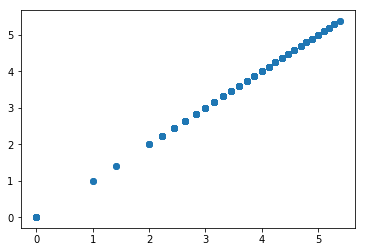

In [178]:
import matplotlib.pyplot as plt
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint


def cluster_sentences(sentences, nb_of_clusters):
        tfidf_vectorizer = TfidfVectorizer()
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        return dict(clusters)



#sentences = ["Nature is beautiful","I like green apples",
 #       "We should protect the trees","Fruit trees provide fruits",
  #      "Green apples are tasty"]
nclusters= 10
clusters = cluster_sentences(clean_texts_list, nclusters)
for cluster in range(nclusters):
        print("cluster ",cluster,":")
        for i,sentence in enumerate(clusters[cluster]):
                print ("\tsentence ",i,": ",title_list[sentence])
                
plt.scatter(eucl_dist_df,eucl_dist_df)

In [179]:
Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(eucl_dist_df)
    Sum_of_squared_distances.append(km.inertia_)

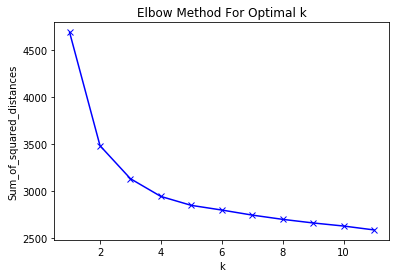

In [180]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [182]:
######### test

import matplotlib.pylab as plt
import scipy.sparse as sparse

#print(plt.spy(count_matrix_title_sparse))

count_matrix_title_test = count_vectorizer.fit_transform(clean_titles_list)
count_matrix_array = count_matrix_title_test.toarray()

print(count_matrix_array)

#tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
#tfidf_matrix = tfidf.fit_transform(clean_titles_list)

#U, s, Vt = np.linalg.svd(count_matrix_array)
#projections = np.dot((U[:,:2]), np.dot(np.diag(s[:2]), Vt.T))

#count_matrix_title_df

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
